In [3]:
# IMPORTING BASE LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
# READING THE DATA

data = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
data.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


**DATA ANALYSIS AND PREPROCESSING**

In [5]:
# CREATING A FUNCTION TO EXPLORE DATA USING BASIC DESCRIPTIVE STATS

def explore(data):
    
    print("Shape of data is:", data.shape,"\n")
    print("Further describing the data:")
    desc = pd.DataFrame(index = list(data))
    desc['count'] = data.count()
    desc['null'] = data.isnull().sum()
    desc['type'] = data.dtypes
    desc = pd.concat([desc, data.describe().T.drop('count', axis = 1)], axis = 1)
    return desc
    
explore(data)

Shape of data is: (136950, 6) 

Further describing the data:


,count,null,type,mean,std,min,25%,50%,75%,max
id,136950,0,int64,68474.500000,39534.204020,0.0,34237.25,68474.5,102711.75,136949.0
date,136950,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,136950,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store,136950,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product,136950,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_sold,136950,0,int64,165.522636,183.691575,2.0,46.00,98.0,184.00,1380.0


In [6]:
# GETTING NO. OF UNIQUE IN EACH COL.

data.nunique()

id          136950
date          1826
country          5
store            3
product          5
num_sold      1028
dtype: int64

In [16]:
# ADDING BASIC DATETIME COLS AND PERFORMING BASIC PREPROCESSING OF THE DATA

def basic_process(data):
    
    data.drop('id', axis = 1, inplace = True)
    data = data.rename({'date':'Date'}, axis = 1)
    data['Date'] = pd.to_datetime(data['Date'])
    data['Day'] = data['Date'].dt.day
    data['Week'] = data['Date'].dt.week
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year
    data.set_index('Date', inplace = True)
    
    return data
    
data = basic_process(data)
data.head()

,country,store,product,num_sold,Day,Week,Month,Year
Date,,,,,,,,
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,1,52,1,2017
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,1,52,1,2017
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,1,52,1,2017
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,1,52,1,2017
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,1,52,1,2017


In [181]:
# FINDING NUMBER OF OUTLIERS IN TARGET VARIABLE

q1 = np.percentile(data['num_sold'], 25)
q3 = np.percentile(data['num_sold'], 75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = [val for val in data['num_sold'] if val < lower_bound or val > upper_bound]

len(outliers)

18906

In [183]:
# AS NUMBER OF OUTLIERS IS HIGH IT IS BETTER TO REPLACE TOP 5 AND LOW 5 PERCENTILE VALUES INSTEAD OF REMOVING OUTLIERS COMPLETELY

lower_threshold = np.percentile(data['num_sold'], 5)
upper_threshold = np.percentile(data['num_sold'], 95)
median = np.median(data['num_sold'])

data['num_sold'] = np.where((data['num_sold'] < lower_threshold) | (data['num_sold'] > upper_threshold),median,data['num_sold'])
data['num_sold']

Date
2017-01-01     63.0
2017-01-01     66.0
2017-01-01     98.0
2017-01-01     59.0
2017-01-01     49.0
              ...  
2021-12-31     98.0
2021-12-31     98.0
2021-12-31    111.0
2021-12-31     98.0
2021-12-31    539.0
Name: num_sold, Length: 136950, dtype: float64

In [31]:
# CREATING SOME NEW COLS. TO EXTRACT MORE INFORMATION

data['Avg_Weekly_Sale'] = data['num_sold'].rolling(window=7, min_periods=1).mean()
data['Avg_Monthly_Sale'] = data['num_sold'].rolling(window=30, min_periods=1).mean()

In [182]:
# CHECKING UNIQUE VALS FOR SOME COLS.

print(data['Year'].unique())
print(data['country'].unique())
print(data['product'].unique())

[2017 2018 2019 2020 2021]
[0 1 2 3 4]
[0 1 2 3 4]


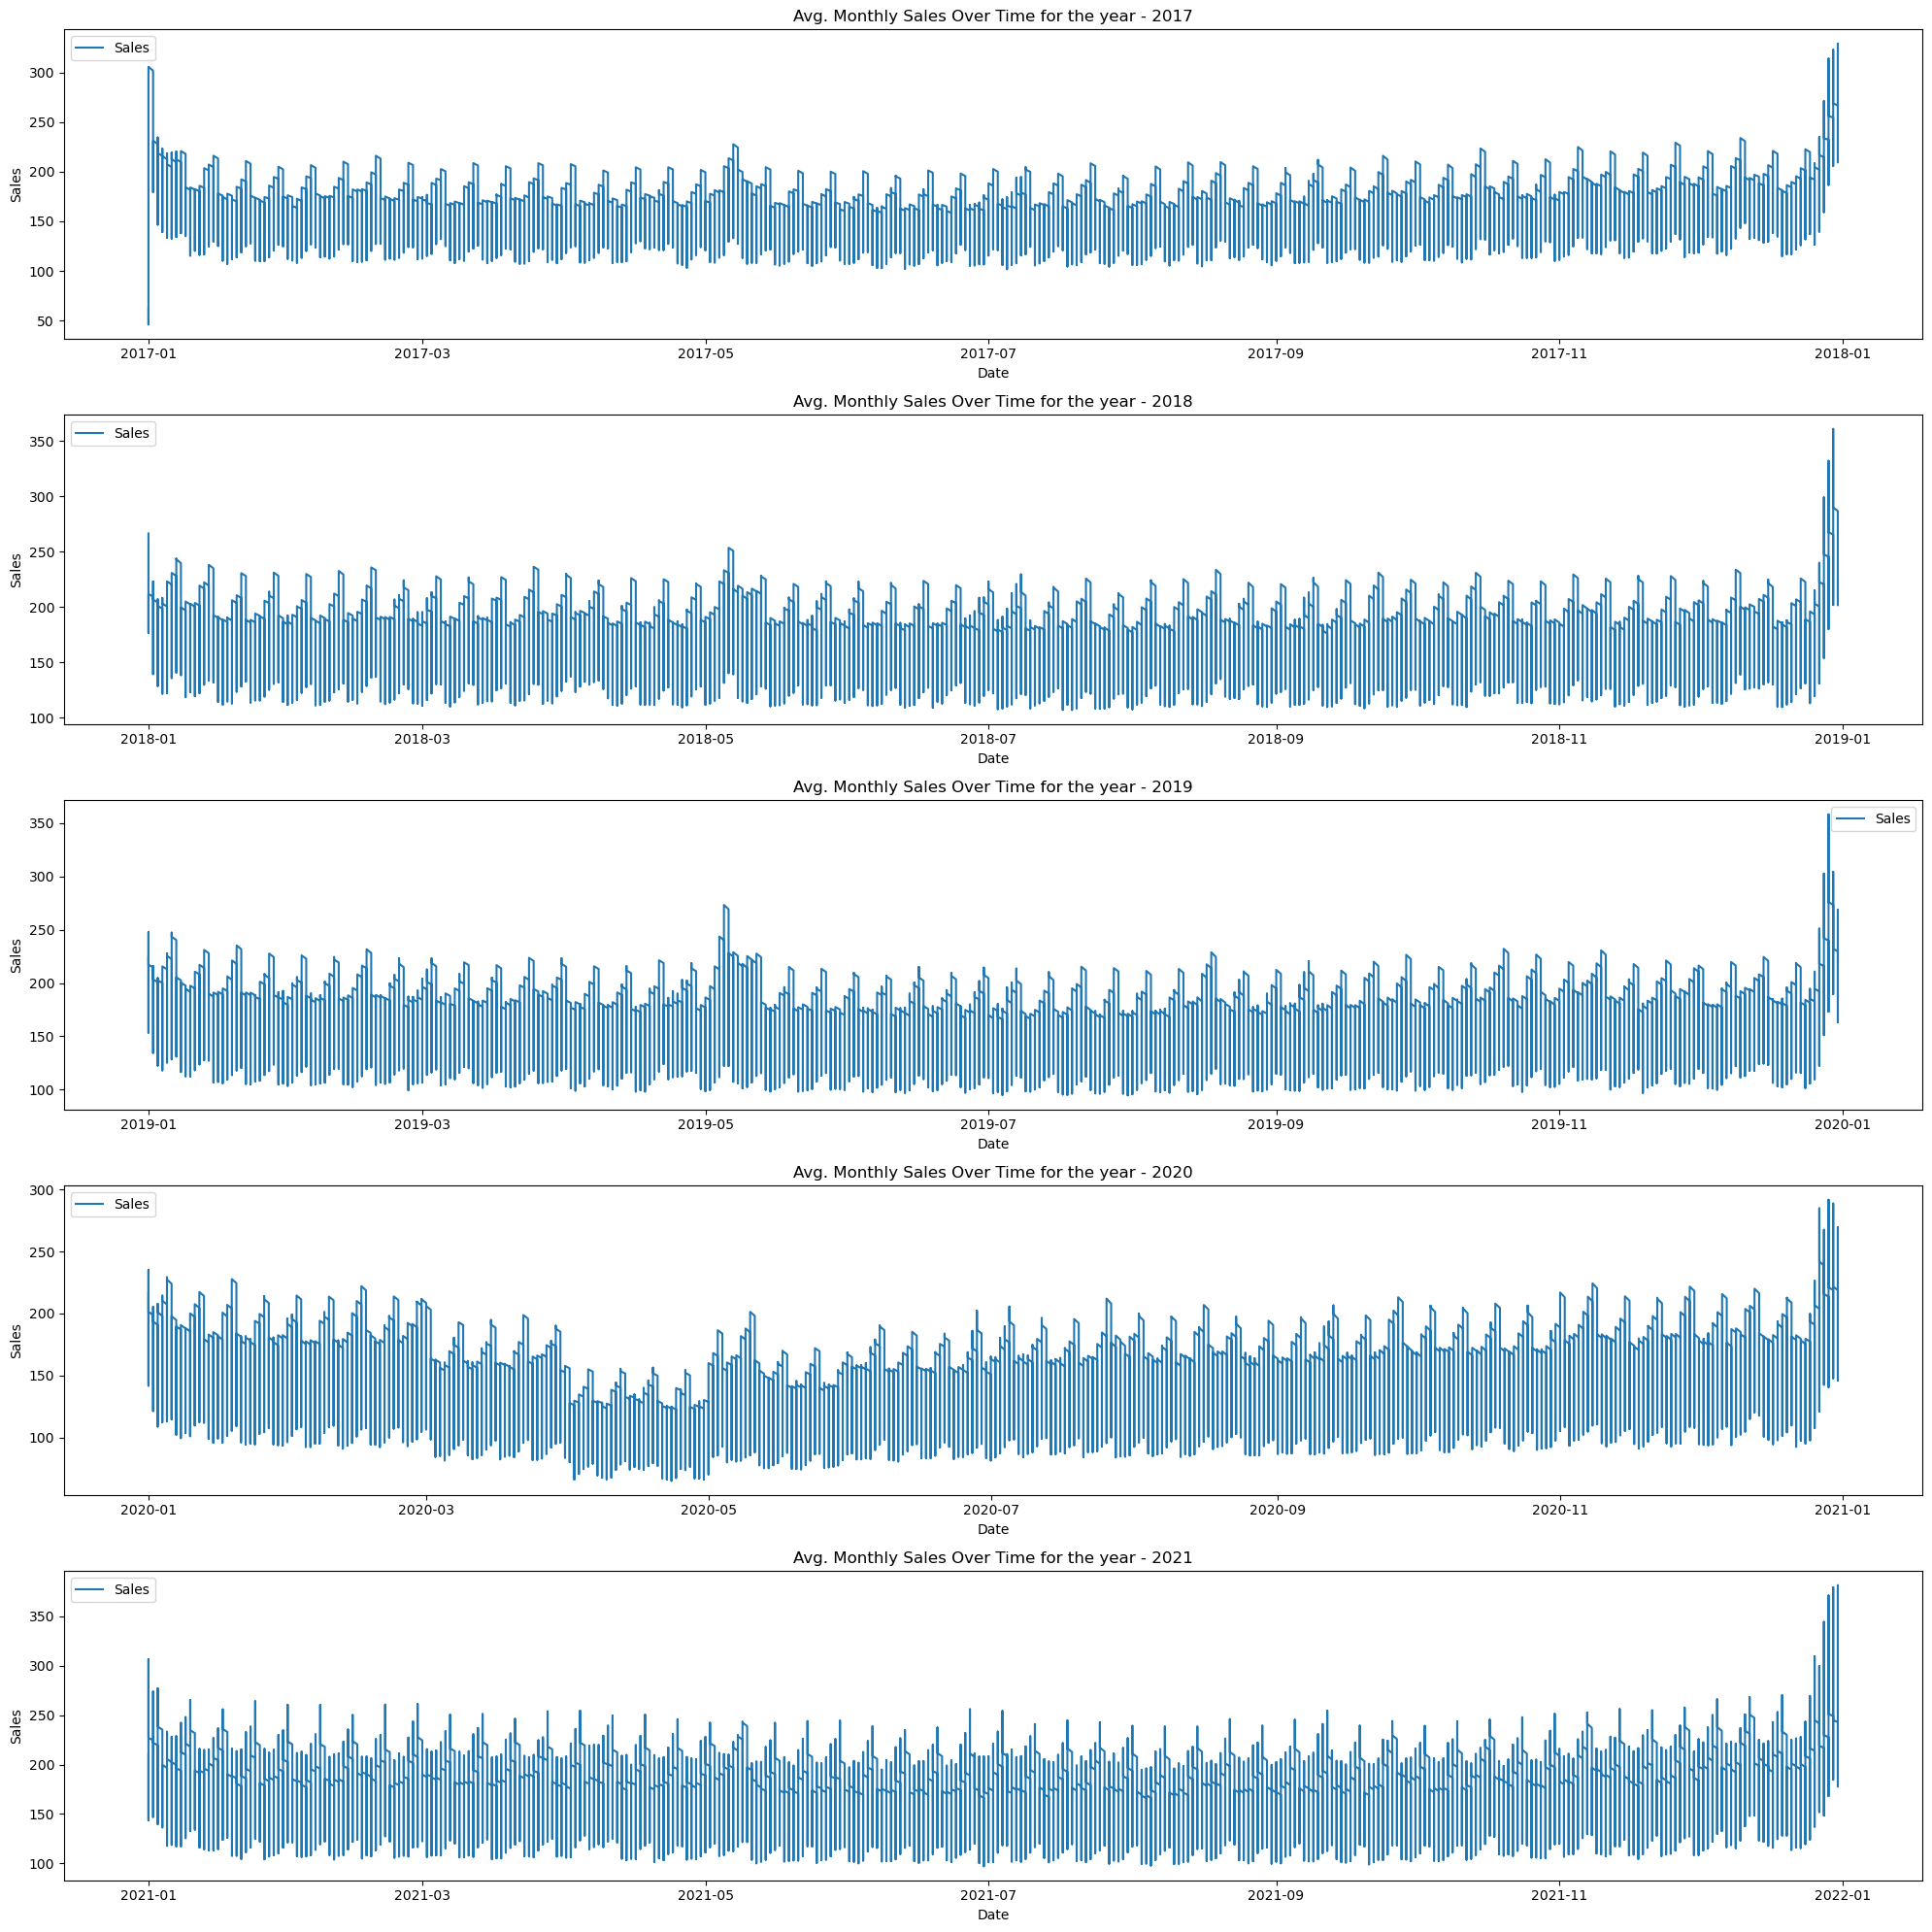

In [42]:
# VISUALIZING AVG. MONTHLY SALES FOR DIFFERENT YEARS

yearly = data.groupby('Year')['Avg_Monthly_Sale']
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 20))

for i, yr in enumerate([2017, 2018, 2019, 2020, 2021]):
    ax = axes[i]
    ax.plot(yearly.get_group(yr), label='Sales')
    ax.set_title(f'Avg. Monthly Sales Over Time for the year - {yr}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend()

plt.tight_layout()

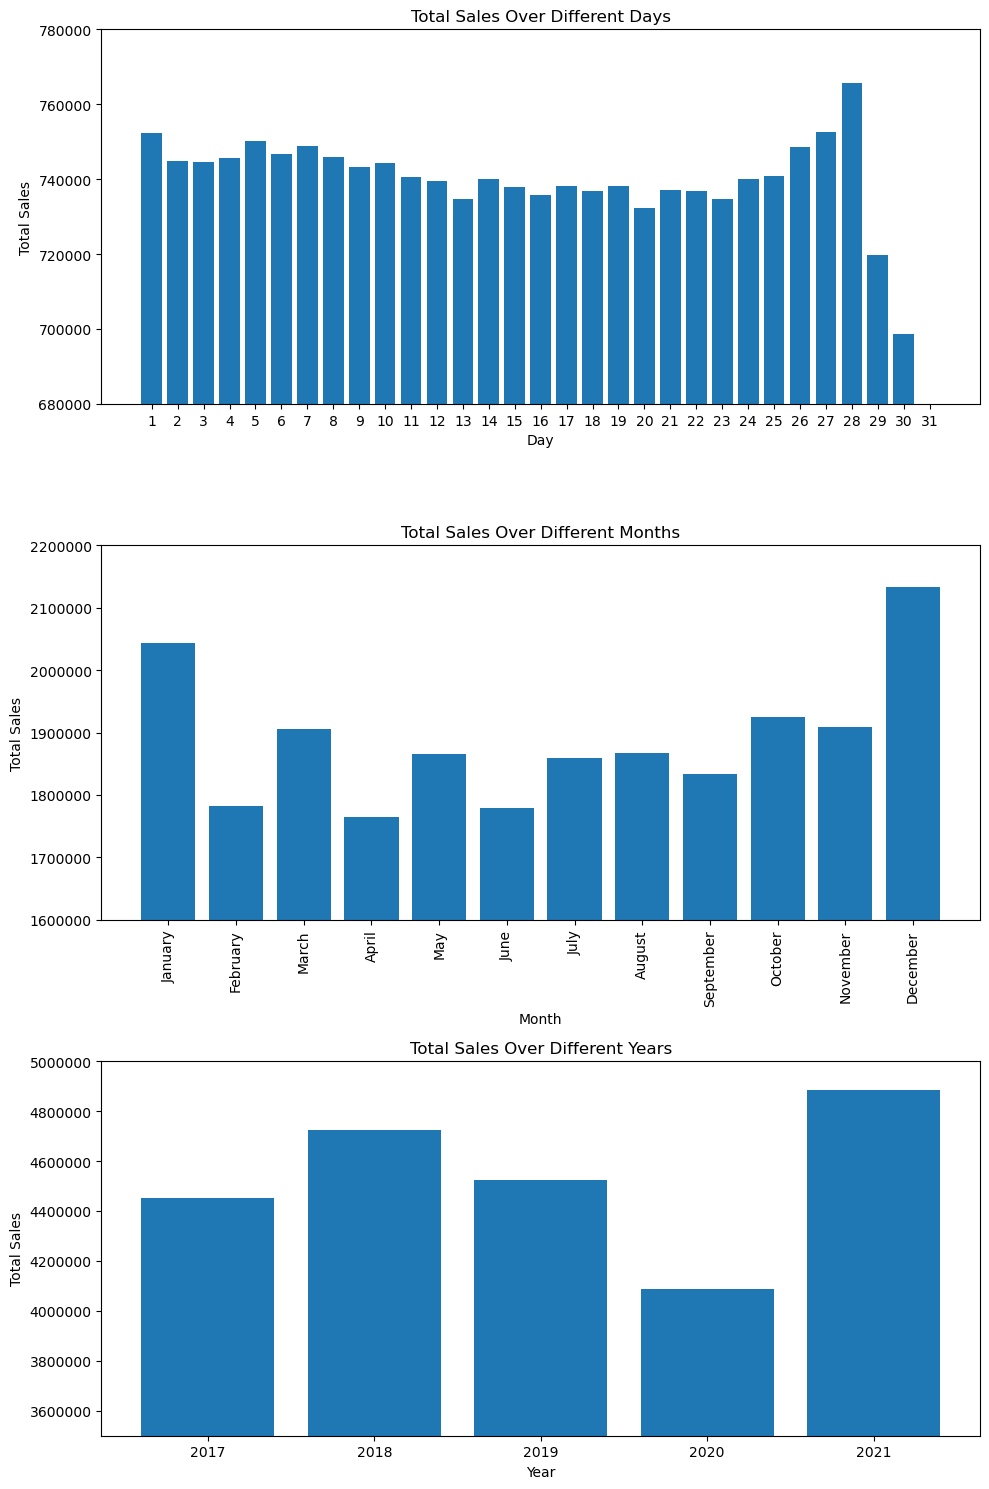

In [50]:
# VISUALIZING TOTAL SALES OVER DAYS, MONTHS AND YEARS

import calendar

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

ax1 = axes[0]
days = sorted(data['Day'].unique())
ax1.bar(days, data.groupby('Day')['num_sold'].sum())
ax1.set_title('Total Sales Over Different Days')
ax1.set_xlabel('Day')
ax1.set_ylabel('Total Sales')
ax1.set_xticks(days)
ax1.set_ylim([680000, 780000])

ax2 = axes[1]
months = [calendar.month_name[i] for i in range(1, 13)]
ax2.bar(range(1, 13), data.groupby('Month')['num_sold'].sum())
ax2.set_title('Total Sales Over Different Months')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Sales')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months, rotation='vertical')
ax2.ticklabel_format(style='plain', axis='y')
ax2.set_ylim([1600000, 2200000])

ax3 = axes[2]
ax3.bar(data['Year'].unique(), data.groupby('Year')['num_sold'].sum())
ax3.set_title('Total Sales Over Different Years')
ax3.set_xlabel('Year')
ax3.set_ylabel('Total Sales')
ax3.ticklabel_format(style='plain', axis='y')
ax3.set_ylim([3500000, 5000000])

plt.tight_layout()
plt.show()

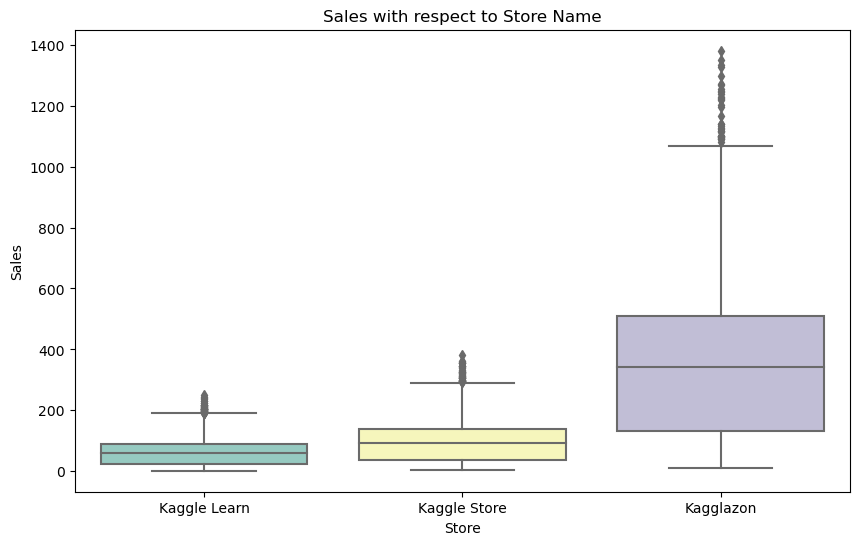

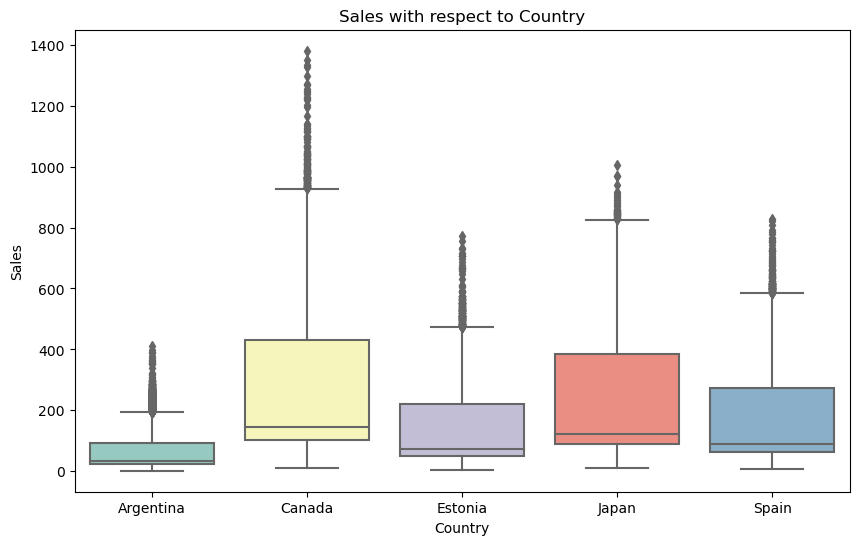

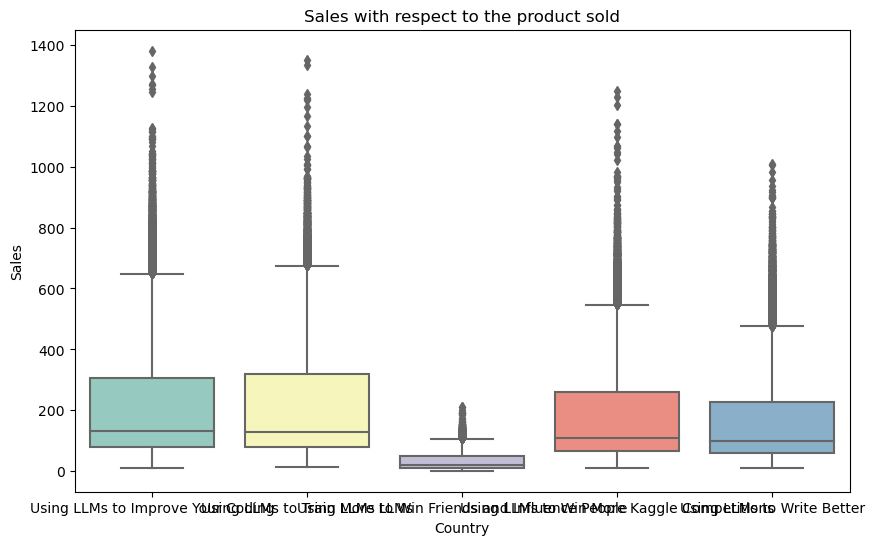

In [59]:
# CREATING BOXPLOTS TO COMPARE SALES W.R.T STORE AND COUNTRY

plt.figure(figsize=(10, 6))
sns.boxplot(x='store', y='num_sold', data= data)
plt.title('Sales with respect to Store Name')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='country', y='num_sold', data= data)
plt.title('Sales with respect to Country')
plt.xlabel('Country')
plt.ylabel('Sales')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='product', y='num_sold', data= data)
plt.title('Sales with respect to the product sold')
plt.xlabel('Country')
plt.ylabel('Sales')
plt.show()

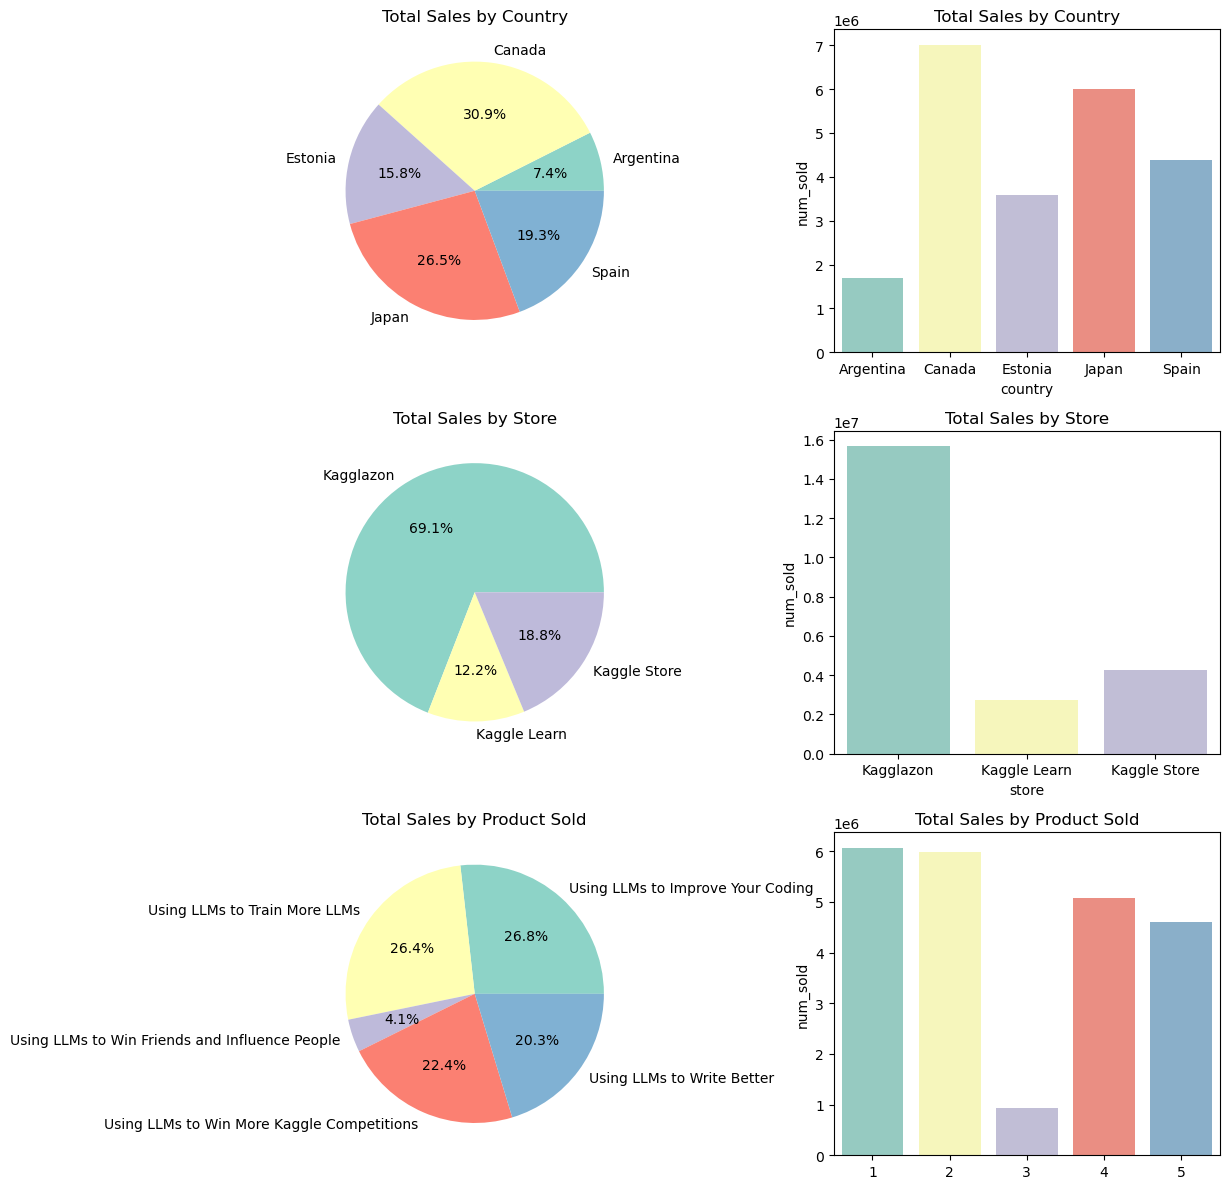

In [68]:
import seaborn as sns

total_sales_country = data.groupby('country')['num_sold'].sum()
total_sales_store = data.groupby('store')['num_sold'].sum()
total_sales_product = data.groupby('product')['num_sold'].sum()

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

axes[0, 0].set_title('Total Sales by Country')
axes[0, 0].pie(total_sales_country, labels=total_sales_country.index, autopct='%1.1f%%')
axes[0, 1].set_title('Total Sales by Country')
sns.barplot(x=total_sales_country.index, y=total_sales_country, ax=axes[0, 1])

axes[1, 0].set_title('Total Sales by Store')
axes[1, 0].pie(total_sales_store, labels=total_sales_store.index, autopct='%1.1f%%')
axes[1, 1].set_title('Total Sales by Store')
sns.barplot(x=total_sales_store.index, y=total_sales_store, ax=axes[1, 1])

axes[2, 0].set_title('Total Sales by Product Sold')
axes[2, 0].pie(total_sales_product, labels=total_sales_product.index, autopct='%1.1f%%')
axes[2, 1].set_title('Total Sales by Product Sold')
sns.barplot(x=[1,2,3,4,5], y=total_sales_product, ax=axes[2, 1])

plt.tight_layout()
plt.show()

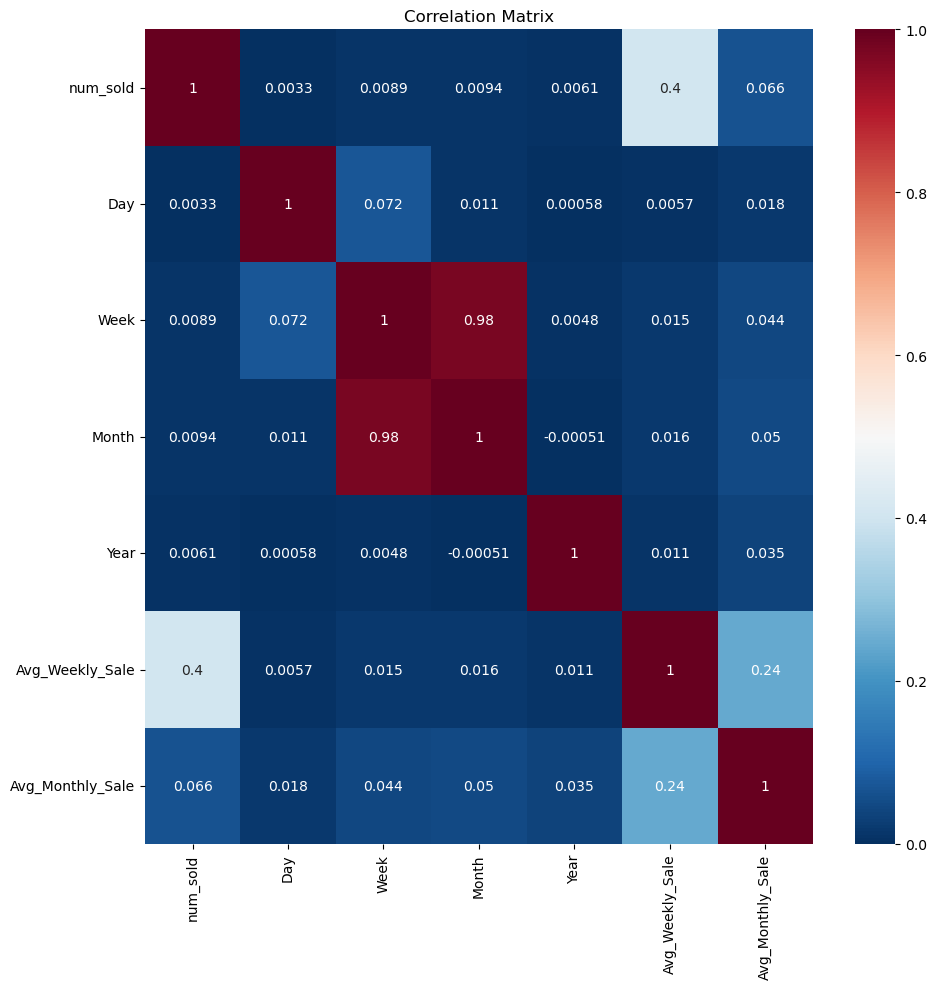

In [52]:
# CREATING A CORRELATION MATRIX TO ANALYSE CORRELATIONS WITHIN VARIABLES

corr_matrix = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

**FEATURE ENGINEERING AND SELECTION**

In [85]:
# FEATURE ENGINEERING SOME NEW FEATURES TO CAPTURE SEASONALITY

data['Quarter'] = data['Month'].apply(lambda x: (x-1)//3 + 1)
data['Day_of_Year'] = data['Month'] * 30 + data['Day']
data['Weekday'] = pd.to_datetime(data['Day'].astype(str) + '-' + data['Month'].astype(str) + '-' + data['Year'].astype(str)).dt.day_name()
data['Is_Weekend'] = data['Weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

data.head()

,country,store,product,num_sold,Day,Week,Month,Year,Avg_Weekly_Sale,Avg_Monthly_Sale,Quarter,Day_of_Year,Weekday,Is_Weekend
Date,,,,,,,,,,,,,,
2017-01-01,0,1,0,63,1,52,1,2017,63.00,63.00,1,31,Sunday,1
2017-01-01,0,1,1,66,1,52,1,2017,64.50,64.50,1,31,Sunday,1
2017-01-01,0,1,2,9,1,52,1,2017,46.00,46.00,1,31,Sunday,1
2017-01-01,0,1,3,59,1,52,1,2017,49.25,49.25,1,31,Sunday,1
2017-01-01,0,1,4,49,1,52,1,2017,49.20,49.20,1,31,Sunday,1


In [131]:
# SEPERATING OUT THE DATA INTO TARGET AND FEATURES

x = data.drop(['num_sold'],axis=1)
y = data['num_sold']

x.head()

,country,store,product,Day,Week,Month,Year,Avg_Weekly_Sale,Avg_Monthly_Sale,Quarter,Day_of_Year,Weekday,Is_Weekend
Date,,,,,,,,,,,,,
2017-01-01,0,1,0,1,52,1,2017,63.00,63.00,1,31,Sunday,1
2017-01-01,0,1,1,1,52,1,2017,64.50,64.50,1,31,Sunday,1
2017-01-01,0,1,2,1,52,1,2017,46.00,46.00,1,31,Sunday,1
2017-01-01,0,1,3,1,52,1,2017,49.25,49.25,1,31,Sunday,1
2017-01-01,0,1,4,1,52,1,2017,49.20,49.20,1,31,Sunday,1


In [132]:
# DROPPING AVG WEEKLY AND AVG. MONTHLY SALES COLUMN AS THEY WERE ONLY USED FOR ANALYSIS AND CANNOT BE AVAILABLE IN UNSEEN DATA

x = x.drop(['Avg_Weekly_Sale', 'Avg_Monthly_Sale'], axis = 1)
x.head()

,country,store,product,Day,Week,Month,Year,Quarter,Day_of_Year,Weekday,Is_Weekend
Date,,,,,,,,,,,
2017-01-01,0,1,0,1,52,1,2017,1,31,Sunday,1
2017-01-01,0,1,1,1,52,1,2017,1,31,Sunday,1
2017-01-01,0,1,2,1,52,1,2017,1,31,Sunday,1
2017-01-01,0,1,3,1,52,1,2017,1,31,Sunday,1
2017-01-01,0,1,4,1,52,1,2017,1,31,Sunday,1


In [133]:
# LABEL ENCODING THE COUNTRY, PRODUCT AND STORE COLUMN (CATEGORICAL COLS)

from sklearn.preprocessing import LabelEncoder

def encode(data, cols):
    for col in cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
    return data

categ_cols = ['product', 'store','country', 'Weekday']
x = encode(x, categ_cols)
x.head()

,country,store,product,Day,Week,Month,Year,Quarter,Day_of_Year,Weekday,Is_Weekend
Date,,,,,,,,,,,
2017-01-01,0,1,0,1,52,1,2017,1,31,3,1
2017-01-01,0,1,1,1,52,1,2017,1,31,3,1
2017-01-01,0,1,2,1,52,1,2017,1,31,3,1
2017-01-01,0,1,3,1,52,1,2017,1,31,3,1
2017-01-01,0,1,4,1,52,1,2017,1,31,3,1


In [94]:
# GETTING BEST FEATURES BASED ON RIDGE REGRESSION

from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(x, y)
feat_coef = pd.Series(ridge.coef_, index=x.columns)
sort_coef = feat_coef.abs().sort_values(ascending=False)
best_feats_ridge = sort_coef.index[:7]  

best_feats_ridge

Index(['store', 'country', 'product', 'Is_Weekend', 'Quarter', 'Year',
       'Weekday'],
      dtype='object')

In [95]:
# GETTING BEST FEATURES BASED ON LASSO REGRESSION

from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(x, y)
l_feat_coef = pd.Series(lasso.coef_, index=x.columns)
l_sort_coef = l_feat_coef.abs().sort_values(ascending=False)
best_feats_lasso = sort_coef.index[:7]  

best_feats_lasso

Index(['store', 'country', 'product', 'Is_Weekend', 'Quarter', 'Year',
       'Weekday'],
      dtype='object')

In [134]:
# TAKING ONLY THE BEST FEATURES AS DECIDED BY LASSO AND RIDGE REGRESSION

x = x[['store', 'country', 'product', 'Is_Weekend', 'Quarter', 'Year','Weekday']]
x.head()

,store,country,product,Is_Weekend,Quarter,Year,Weekday
Date,,,,,,,
2017-01-01,1,0,0,1,1,2017,3
2017-01-01,1,0,1,1,1,2017,3
2017-01-01,1,0,2,1,1,2017,3
2017-01-01,1,0,3,1,1,2017,3
2017-01-01,1,0,4,1,1,2017,3


**FITTING MODELS TO FORECAST TIME SERIES**

In [195]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train

,store,country,product,Is_Weekend,Quarter,Year,Weekday
Date,,,,,,,
2018-08-16,0,3,0,0,3,2018,4
2019-01-30,1,1,2,0,1,2019,6
2020-06-19,2,1,0,0,2,2020,0
2019-04-22,2,3,2,0,2,2019,1
2017-01-30,2,2,2,0,1,2017,1
...,...,...,...,...,...,...,...
2021-01-10,1,1,3,0,1,2021,0
2021-05-18,0,1,4,0,2,2021,5
2020-10-14,0,2,4,0,4,2020,6


In [186]:
# FINDING BEST PARAMETERS FOR A CATBOOST MODEL

from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'iterations': [500, 100], 'learning_rate': [0.05, 0.1]}

catboost_model = CatBoostRegressor(loss_function='MAE')
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=2)

grid_search.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=100, verbose=False)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.1}
Best score: -0.977173847422846


In [187]:
# FITTING A CATBOOST MODEL TO OUR DATA ACCORDING TO THE BEST HYPERPARAMETERS FOUND

best_params = grid_search.best_params_

catboost_model = CatBoostRegressor(loss_function='MAE', random_seed=42, **best_params)
catboost_model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=100)

0:	learn: 106.7062712	test: 106.3371000	best: 106.3371000 (0)	total: 24.3ms	remaining: 24.3s
1:	learn: 96.5448265	test: 96.2243288	best: 96.2243288 (1)	total: 46.7ms	remaining: 23.3s
2:	learn: 87.4342639	test: 87.1546738	best: 87.1546738 (2)	total: 69.2ms	remaining: 23s
3:	learn: 79.2719792	test: 79.0294148	best: 79.0294148 (3)	total: 93ms	remaining: 23.2s
4:	learn: 71.9638829	test: 71.7596400	best: 71.7596400 (4)	total: 116ms	remaining: 23s
5:	learn: 65.5179529	test: 65.3469988	best: 65.3469988 (5)	total: 139ms	remaining: 23.1s
6:	learn: 59.6873485	test: 59.5480862	best: 59.5480862 (6)	total: 162ms	remaining: 23s
7:	learn: 54.5128292	test: 54.3932934	best: 54.3932934 (7)	total: 185ms	remaining: 22.9s
8:	learn: 50.0001010	test: 49.8972645	best: 49.8972645 (8)	total: 208ms	remaining: 22.9s
9:	learn: 46.0106758	test: 45.9196177	best: 45.9196177 (9)	total: 233ms	remaining: 23.1s
10:	learn: 42.4755843	test: 42.3909403	best: 42.3909403 (10)	total: 259ms	remaining: 23.3s
11:	learn: 39.347658

In [202]:
# FITTING AN LSTM MODEL TO OUR DATA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

x_train_reshaped = np.expand_dims(x_train, axis=1)

lstm_model = Sequential()
lstm_model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
lstm_model.add(LSTM(64, activation='relu', return_sequences=True))
lstm_model.add(LSTM(32, activation='relu'))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32)

Epoch 1/10
3424/3424 [==============================] - 33s 8ms/step - loss: 120.8030
Epoch 2/10
3424/3424 [==============================] - 28s 8ms/step - loss: 114.6818
Epoch 3/10
3424/3424 [==============================] - 28s 8ms/step - loss: 89.3570
Epoch 4/10
3424/3424 [==============================] - 28s 8ms/step - loss: 83.7584
Epoch 5/10
3424/3424 [==============================] - 28s 8ms/step - loss: 81.2309
Epoch 6/10
3424/3424 [==============================] - 28s 8ms/step - loss: 78.3420
Epoch 7/10
3424/3424 [==============================] - 28s 8ms/step - loss: 76.8368
Epoch 8/10
3424/3424 [==============================] - 29s 8ms/step - loss: 67.5779
Epoch 9/10
3424/3424 [==============================] - 28s 8ms/step - loss: 71.7009
Epoch 10/10
3424/3424 [==============================] - 28s 8ms/step - loss: 61.9999


In [204]:
# MAKING PREDICTIONS WITH OUT TRAINED MODELS

catb_preds = catboost_model.predict(x_test)
lstm_preds = lstm_model.predict(np.expand_dims(x_test, axis=1))

856/856 [==============================] - 4s 4ms/step


In [206]:
# EVALUATION OF CATBOOST MODEL

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

catb_r2 = r2_score(y_test, catb_preds)
catb_mae = mean_absolute_error(y_test, catb_preds)
catb_rmse = np.sqrt(mean_squared_error(y_test, catb_preds))

print("R2 score of Catboost model is:", catb_r2)
print("MAE score of Catboost model is:", catb_mae)
print("RMSE score of Catboost model is:", catb_rmse)

R2 score of Catboost model is: 0.9779269211412039
MAE score of Catboost model is: 13.054454854149947
RMSE score of Catboost model is: 27.29509943207388


In [207]:
# EVALUATION OF LSTM MODEL

lstm_r2 = r2_score(y_test, lstm_preds)
lstm_mae = mean_absolute_error(y_test, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))

print("R2 score of LSTM model is:", lstm_r2)
print("MAE score of LSTM model is:", lstm_mae)
print("RMSE score of LSTM model is:", lstm_rmse)

R2 score of LSTM model is: 0.7032006497527397
MAE score of LSTM model is: 58.399540660867906
RMSE score of LSTM model is: 100.08861881937196


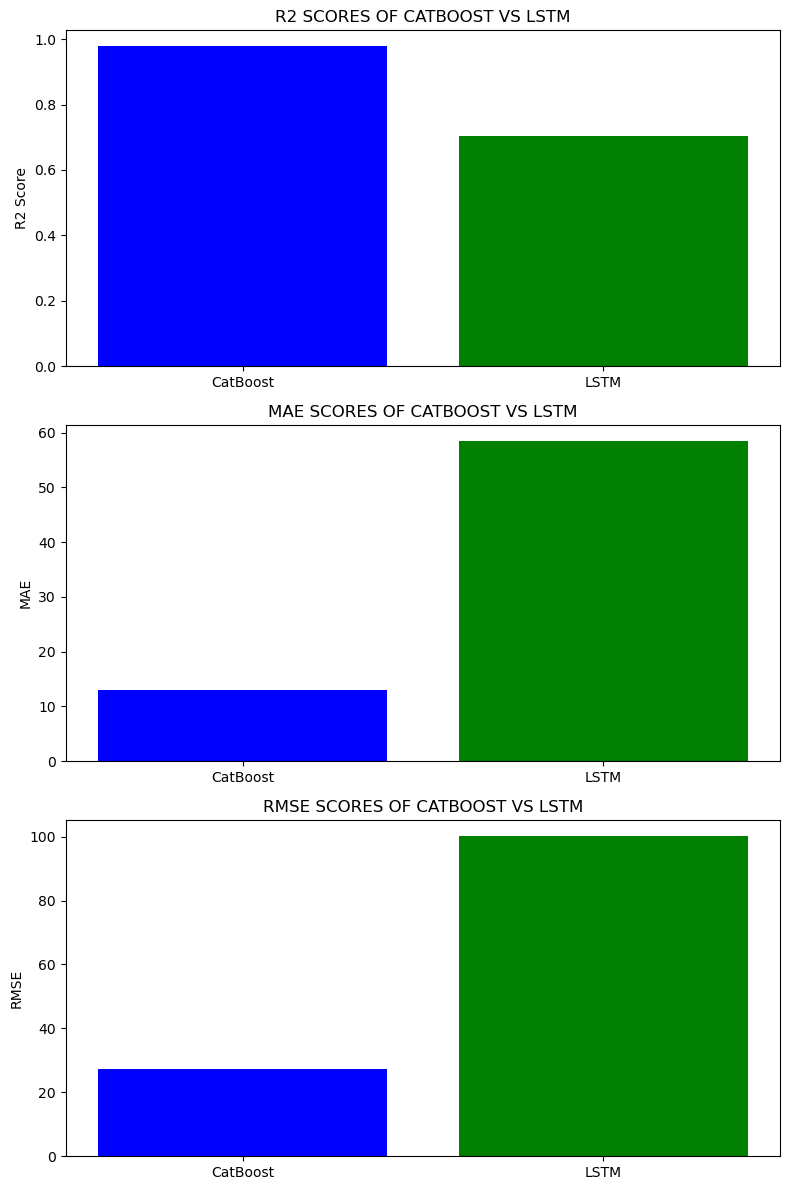

In [215]:
# COMPARING THE TWO MODELS

r2_scores = [catb_r2, lstm_r2]
mae_scores = [catb_mae, lstm_mae]
rmse_scores = [catb_rmse, lstm_rmse]
labels = ['CatBoost', 'LSTM']

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

axes[0].bar(labels, r2_scores, color=['blue', 'green'])
axes[0].set_ylabel('R2 Score')
axes[0].set_title('R2 SCORES OF CATBOOST VS LSTM')

axes[1].bar(labels, mae_scores, color=['blue', 'green'])
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE SCORES OF CATBOOST VS LSTM')

axes[2].bar(labels, rmse_scores, color=['blue', 'green'])
axes[2].set_ylabel('RMSE')
axes[2].set_title('RMSE SCORES OF CATBOOST VS LSTM')

plt.tight_layout()
plt.show()